In [1]:
from neurolib.utils.loadData import Dataset
import os
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.spatial import distance
from sklearn.cluster import KMeans
from tqdm import tqdm
from itertools import combinations
# import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import datasets
from nilearn import plotting
# import nctpy functions
from nctpy.energies import integrate_u, get_control_inputs
from nctpy.metrics import ave_control, modal_control
from nctpy.utils import (
matrix_normalization,
normalize_state,
normalize_weights,
)
from nctpy.plotting import roi_to_vtx, null_plot, surface_plot, add_module_lines, set_plotting_params, reg_plot


In [2]:
dataset = Dataset("hcp")

# structural connectivity adjacency matrix
A = dataset.Cmat
A.shape
n_nodes = A.shape[0]

print(f"Number of nodes: {n_nodes}")
A[A < 0.01] = 0
print(A)

Number of nodes: 80
[[0.         0.07906338 0.20767269 ... 0.         0.0362114  0.        ]
 [0.07906338 0.         0.02107246 ... 0.         0.         0.0205666 ]
 [0.20767269 0.02107246 0.         ... 0.         0.01315564 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.16260376]
 [0.0362114  0.         0.01315564 ... 0.         0.         0.        ]
 [0.         0.0205666  0.         ... 0.16260376 0.         0.        ]]


In [3]:
# strength function
def node_strength(A):
    str = np.sum(A, axis=0)

    return str

In [4]:
system = 'continuous'
A_norm = matrix_normalization(A, system, c=1)

In [5]:
ns = node_strength(A)

# Modal Controllability

In [6]:
mc = modal_control(A_norm)
print(mc)

[-0.0538286  -0.04090192 -0.14655749 -0.1293777  -0.12795481 -0.11608223
 -0.01992132 -0.02096449 -0.04074972 -0.03348968 -0.00930755 -0.00472232
 -0.02198695 -0.01888385 -0.03079911 -0.04036464 -0.00179716 -0.00301349
 -0.06312222 -0.05457381 -0.00757988 -0.011023   -0.00546041 -0.0049965
 -0.00204208 -0.00175178 -0.00299677 -0.00258504 -0.00424397 -0.0026039
 -0.00112131 -0.00043974 -0.02859583 -0.01659195 -0.02609586 -0.03317262
 -0.03585138 -0.06057628 -0.012232   -0.01540403 -0.0578947  -0.0657353
 -0.04229136 -0.05412717 -0.04065321 -0.04492344 -0.04384828 -0.04178443
 -0.06743398 -0.03670828 -0.02153293 -0.01412556 -0.0385849  -0.04177779
 -0.0623441  -0.04977117 -0.03826036 -0.02817806 -0.05467201 -0.02783539
 -0.02497002 -0.03473995 -0.02370063 -0.02447709 -0.07711279 -0.08958571
 -0.00738599 -0.00720719 -0.00281625 -0.00363597 -0.06107078 -0.06351345
 -0.00980041 -0.00798056 -0.12208381 -0.10718353 -0.00632025 -0.00910647
 -0.07811794 -0.06961511]


# Average Controllability 

In [7]:
ac = ave_control(A_norm=A_norm, system=system)
print(ac)

[0.44218547 0.43969574 0.45867032 0.45562212 0.45511901 0.45288261
 0.43606267 0.43622183 0.43977613 0.43835172 0.43398944 0.43315491
 0.43631235 0.43568144 0.43813405 0.43977709 0.4326421  0.43285522
 0.44413089 0.44248489 0.433692   0.4343426  0.43326674 0.43317557
 0.43267213 0.43262041 0.43287532 0.43278311 0.43304967 0.43276489
 0.43252443 0.43240465 0.43755766 0.43527419 0.43715254 0.4385759
 0.43906231 0.44377902 0.43484854 0.43549594 0.4434031  0.44502106
 0.44049906 0.44274968 0.43976166 0.44059689 0.44060487 0.44015345
 0.44523373 0.439196   0.43631368 0.43498604 0.43924137 0.43985288
 0.44351608 0.4410635  0.43948278 0.43756778 0.44229563 0.43728049
 0.43698068 0.43856364 0.43669907 0.43687539 0.44751011 0.44997639
 0.4337144  0.43366042 0.43283106 0.43296488 0.44326181 0.44354405
 0.43412056 0.43375424 0.45442022 0.45127572 0.43350159 0.43401229
 0.44630844 0.44465641]


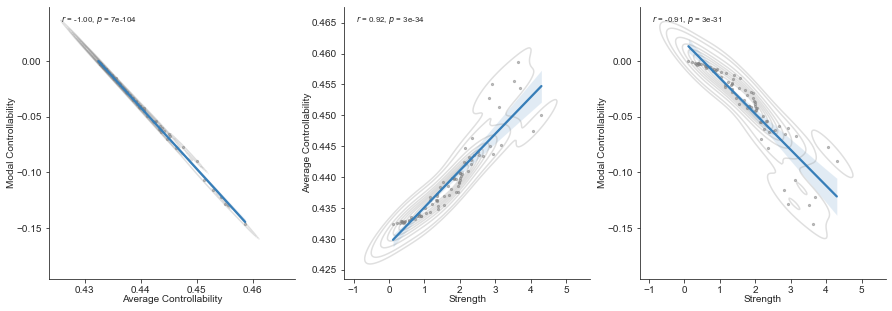

In [8]:
set_plotting_params()
f, ax = plt.subplots(1, 3, figsize=(15, 5))

reg_plot(x=ac, y=mc,
         xlabel='Average Controllability', ylabel='Modal Controllability',
         annotate='pearson', ax=ax[0])

reg_plot(x=ns, y=ac,
         xlabel='Strength', ylabel='Average Controllability',
         annotate='pearson', ax=ax[1])

reg_plot(x=ns, y=mc,
         xlabel='Strength', ylabel='Modal Controllability',
         annotate='pearson', ax=ax[2])

plt.show()

# Control Energy

In [9]:
# define initial and target states as random patterns of activity
np.random.seed(42)  
x0 = np.random.rand(n_nodes, 1)  # initial state
xf = np.random.rand(n_nodes, 1)  # target state

# specify a uniform full control set: all nodes are control nodes
# and all control nodes are assigned equal control weight
control_set = np.eye(n_nodes)

# set parameters
time_horizon = 1  # time horizon (T)
rho = 1  # mixing parameter for state trajectory constraint
trajectory_constraints = np.eye(n_nodes)  # nodes in state trajectory to be constrained

# get the state trajectory (x) and the control inputs (u)
state_trajectory, control_signals, numerical_error = get_control_inputs(
    A_norm=A_norm,
    T=time_horizon,
    B=control_set,
    x0=x0,
    xf=xf,
    system=system,
    rho=rho,
    S=trajectory_constraints,
)


# print errors
thr = 1e-8
# the first numerical error corresponds to the inversion error
print(
    "inversion error = {:.2E} (<{:.2E}={:})".format(
numerical_error[0], thr, numerical_error[0] < thr
)
)
# the second numerical error corresponds to the reconstruction error
print(
"reconstruction error = {:.2E} (<{:.2E}={:})".format(
    numerical_error[1], thr, numerical_error[1] < thr
) )

inversion error = 1.63E-15 (<1.00E-08=True)
reconstruction error = 1.78E-13 (<1.00E-08=True)


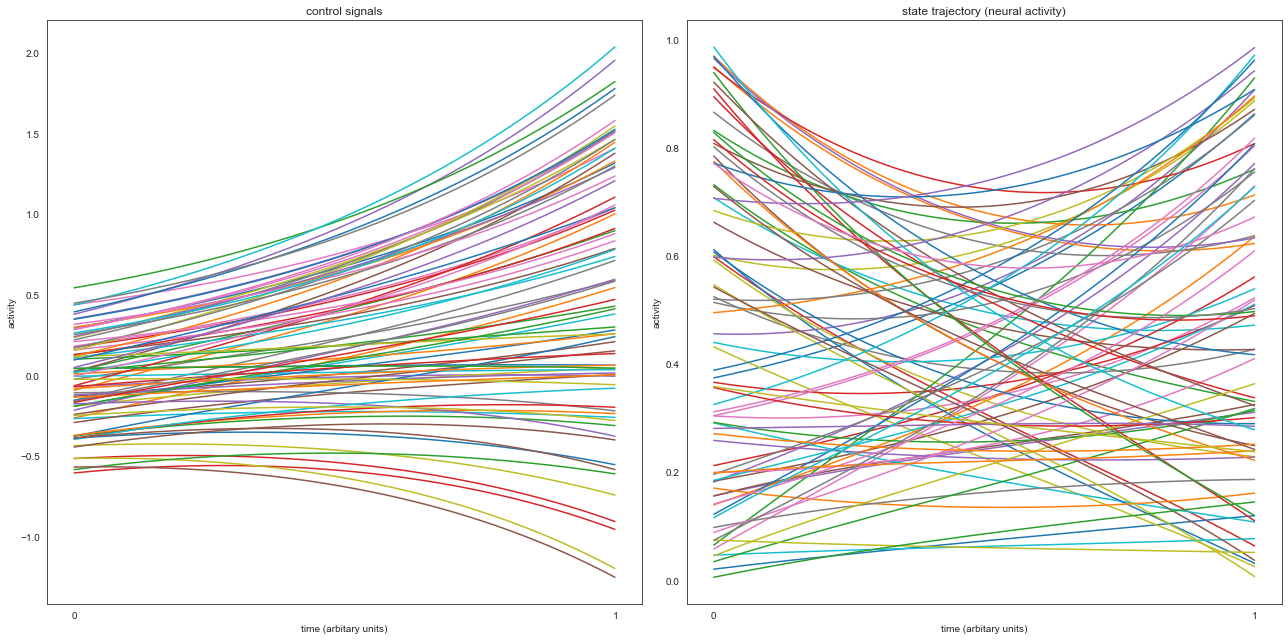

In [10]:
# Visualize state trajectory (x) and control signals(u) 

f, ax = plt.subplots(1, 2, figsize=(18, 9))
# plot control signals for initial state
ax[0].plot(control_signals)
ax[0].set_title('control signals')

# plot state trajectory for initial state
ax[1].plot(state_trajectory)
ax[1].set_title('state trajectory (neural activity)')

for cax in ax.reshape(-1):
    cax.set_ylabel("activity")
    cax.set_xlabel("time (arbitary units)")
    cax.set_xticks([0, state_trajectory.shape[0]])
    cax.set_xticklabels([0, time_horizon])

f.tight_layout()
plt.show()

In [11]:
# integrate control inputs to get control energy
node_energy = integrate_u(control_signals)

# summarize nodal energy to get control energy
energy = np.sum(node_energy)
print(np.round(energy, 2))

24819.5


In [16]:
class ComputeControlEnergy():
    """This class will compute control energy for a set of independent control tasks stored in control_tasks.
    See /scripts/control_energy_wrapper.ipynb for an example.

    """
    def __init__(self, A, control_tasks, system=None, c=1, T=1, control_size=None):
        """Initializes inputs to ComputeControlEnergy

        Args:
            A (NxN, numpy array): adjacency matrix representing a structural connectome.
            control_tasks (list): list of control tasks wherein each entry is a dictionary variable.
                For example,
                    control_tasks = []  # list of tasks

                    control_task = dict()  # initialize dict
                    control_task['x0'] = x0  # store initial state
                    control_task['xf'] = xf  # store target state
                    control_task['B'] = B  # store control nodes
                    control_task['S'] = S  # store state trajectory constraints
                    control_task['rho'] = rho  # store rho
                    control_tasks.append(control_task)
                See get_control_inputs for information on above inputs.
            system (str): string variable that determines whether A is normalized for a continuous-time system or a
                discrete-time system. options: 'continuous' or 'discrete'. default=None.
            c (int): normalization constant, default=1.
            T (float): time horizon.

        """

        self.A = A
        self.control_tasks = control_tasks

        self.system = system
        self.c = c
        self.T = T
        self.control_size = control_size
        self.numerical_threshold = 1e-8  # Define numerical error threshold

    def _check_inputs(self):
        if self.A.shape[0] == self.A.shape[1]:
            self.n_nodes = self.A.shape[0]
        elif self.A.shape[0] != self.A.shape[1]:
            raise Exception("A matrix is not square. This routine requires A.shape[0] == A.shape[1]")

        try:
            A_norm = self.A_norm
        except AttributeError:
            self.A_norm = matrix_normalization(self.A, system=self.system, c=self.c)
            
            
    def _get_energy(self, B):
        if self.control_tasks['rho'] == 0:
            S = np.eye(self.n_nodes)
        else:
            S = self.control_tasks['S']
        state_trajectory, control_signals, numerical_error = get_control_inputs(A_norm=self.A_norm, T=self.T, B=B,
                                     x0=self.control_tasks['x0'], xf=self.control_tasks['xf'], system=self.system,
                                     rho=self.control_tasks['rho'], S=S)
        
        # Check numerical errors
        if numerical_error[0] >= self.numerical_threshold or numerical_error[1] >= self.numerical_threshold:
            return float('inf')  # Return high energy if numerical errors are too large
        
        E = integrate_u(control_signals)
        E = np.sum(E)
        return E
    

    def run(self):
        self._check_inputs()
        E = []
        B = []

        for control_task in tqdm(self.control_tasks):
            if self.control_size is None:
                raise ValueError("Control size must be specified.")
        
            all_combinations = combinations(range(self.n_nodes), self.control_size)
            min_energy = float('inf')
            best_B = None
            success = False

            for comb in tqdm(all_combinations):
                B = np.zeros((self.n_nodes, self.n_nodes))
                for i in comb:
                    B[i, i] = 1

                B_I = B.copy() 
                E = self._get_energy(B=B)

                if E == float('inf'):
                    continue  # Skip this combination due to numerical errors
                
                
                if E < min_energy:
                    min_energy = E
                    best_B = B_I 
                    success = True

            if not success:
                raise ValueError("No successful transition found with the given control size.")


            # get energy
            E.append(min_energy)
            B.append(best_B)

        # store outputs as array
        self.E = np.array(E)
        self.B = np.array(B)

In [17]:
control_task = dict()  # initialize dict
control_task["x0"] = x0  # store initial state
control_task["xf"] = xf  # store target state
control_task["S"] = trajectory_constraints  # store state trajectory constraints
control_task["rho"] = rho  # store rho
compute_control_energy = ComputeControlEnergy(
    A=A,
   control_tasks=control_task,
    system=system,
    c=1,
    T=time_horizon,
    control_size=5,
   
)

compute_control_energy.run()

  0%|                                                     | 0/4 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  9.19it/s]
3it [00:00, 10.15it/s]
4it [00:00,  9.80it/s]
6it [00:00, 10.10it/s]
7it [00:00,  9.88it/s]
9it [00:00,  9.63it/s]
11it [00:01, 10.26it/s]
13it [00:01, 10.90it/s]
15it [00:01, 11.12it/s]
17it [00:01, 11.21it/s]
19it [00:01, 11.38it/s]
21it [00:01, 11.35it/s]
23it [00:02, 11.28it/s]
25it [00:02, 10.53it/s]
27it [00:02, 10.82it/s]
29it [00:02, 11.06it/s]
31it [00:02, 11.26it/s]
33it [00:03, 10.94it/s]
35it [00:03, 10.98it/s]
37it [00:03, 11.21it/s]
39it [00:03, 11.24it/s]
41it [00:03, 11.23it/s]
43it [00:03, 11.12it/s]
45it [00:04, 10.88it/s]
47it [00:04, 11.08it/s]
49it [00:04, 11.23it/s]
51it [00:04, 11.07it/s]
53it [00:04, 10.31it/s]
55it [00:05, 10.68it/s]
57it [00:05, 10.69it/s]
59it [00:05, 10.15it/s]
61it [00:05, 10.26it/s]
63it [00:05, 10.61it/s]
65it [00:06, 10.75it/s]
67it [00:06, 10.50it/s]
69it [00:06,  9.99it/s]
71it [00:06, 10.44it/s]
73it [00:06, 10.53

570it [00:52, 10.23it/s]
572it [00:52, 10.55it/s]
574it [00:52, 10.64it/s]
576it [00:52, 10.68it/s]
578it [00:52, 10.80it/s]
580it [00:53, 10.75it/s]
582it [00:53, 11.01it/s]
584it [00:53, 10.62it/s]
586it [00:53, 10.89it/s]
588it [00:53, 11.17it/s]
590it [00:53, 11.09it/s]
592it [00:54, 10.87it/s]
594it [00:54, 10.89it/s]
596it [00:54, 10.63it/s]
598it [00:54, 10.70it/s]
600it [00:54, 11.21it/s]
602it [00:55, 11.29it/s]
604it [00:55, 11.42it/s]
606it [00:55, 11.29it/s]
608it [00:55, 11.25it/s]
610it [00:55, 10.82it/s]
612it [00:55, 10.94it/s]
614it [00:56, 10.91it/s]
616it [00:56, 11.09it/s]
618it [00:56, 11.18it/s]
620it [00:56, 11.42it/s]
622it [00:56, 11.50it/s]
624it [00:56, 11.54it/s]
626it [00:57, 11.66it/s]
628it [00:57, 11.53it/s]
630it [00:57, 11.39it/s]
632it [00:57, 11.53it/s]
634it [00:57, 11.58it/s]
636it [00:58, 11.50it/s]
638it [00:58, 11.22it/s]
640it [00:58, 11.07it/s]
642it [00:58, 11.17it/s]
644it [00:58, 11.14it/s]
646it [00:58, 11.28it/s]
648it [00:59, 11.10it/s]


1142it [01:43, 10.86it/s]
1144it [01:43, 11.35it/s]
1146it [01:44, 11.09it/s]
1148it [01:44, 11.15it/s]
1150it [01:44, 11.23it/s]
1152it [01:44, 11.19it/s]
1154it [01:44, 10.63it/s]
1156it [01:45, 10.61it/s]
1158it [01:45, 10.95it/s]
1160it [01:45, 10.78it/s]
1162it [01:45, 11.07it/s]
1164it [01:45, 10.19it/s]
1166it [01:46, 10.10it/s]
1168it [01:46, 10.28it/s]
1170it [01:46,  9.91it/s]
1172it [01:46,  9.51it/s]
1173it [01:46,  9.55it/s]
1174it [01:46,  9.53it/s]
1176it [01:47,  9.76it/s]
1177it [01:47,  9.77it/s]
1179it [01:47, 10.02it/s]
1180it [01:47,  9.95it/s]
1181it [01:47,  9.71it/s]
1182it [01:47,  9.66it/s]
1183it [01:47,  9.72it/s]
1185it [01:47, 10.49it/s]
1187it [01:48, 10.45it/s]
1189it [01:48, 10.66it/s]
1191it [01:48, 10.61it/s]
1193it [01:48, 10.38it/s]
1195it [01:48, 10.08it/s]
1197it [01:49, 10.35it/s]
1199it [01:49, 10.55it/s]
1201it [01:49, 10.55it/s]
1203it [01:49, 10.90it/s]
1205it [01:49, 11.11it/s]
1207it [01:49, 11.15it/s]
1209it [01:50, 11.40it/s]
1211it [01:5

1692it [02:34,  9.88it/s]
1694it [02:34,  9.84it/s]
1695it [02:35,  9.81it/s]
1697it [02:35, 10.57it/s]
1699it [02:35, 10.39it/s]
1701it [02:35, 10.63it/s]
1703it [02:35, 10.75it/s]
1705it [02:36,  9.94it/s]
1707it [02:36, 10.39it/s]
1709it [02:36, 10.74it/s]
1711it [02:36, 10.56it/s]
1713it [02:36, 10.89it/s]
1715it [02:36, 10.84it/s]
1717it [02:37, 11.37it/s]
1719it [02:37, 11.23it/s]
1721it [02:37,  9.98it/s]
1723it [02:37,  9.85it/s]
1725it [02:37, 10.07it/s]
1727it [02:38, 10.02it/s]
1729it [02:38, 10.10it/s]
1731it [02:38, 10.39it/s]
1733it [02:38, 10.47it/s]
1735it [02:38, 10.05it/s]
1737it [02:39, 10.41it/s]
1739it [02:39,  9.96it/s]
1741it [02:39, 10.63it/s]
1743it [02:39, 11.15it/s]
1745it [02:39, 11.02it/s]
1747it [02:39, 10.96it/s]
1749it [02:40, 10.36it/s]
1751it [02:40, 10.86it/s]
1753it [02:40, 11.41it/s]
1755it [02:40, 11.18it/s]
1757it [02:40, 11.33it/s]
1759it [02:41, 11.28it/s]
1761it [02:41, 11.39it/s]
1763it [02:41, 11.17it/s]
1765it [02:41, 10.91it/s]
1767it [02:4

2229it [03:26, 10.38it/s]
2231it [03:26, 10.34it/s]
2233it [03:26, 10.70it/s]
2235it [03:26, 10.04it/s]
2237it [03:26, 10.03it/s]
2239it [03:27, 10.38it/s]
2241it [03:27, 10.72it/s]
2243it [03:27, 10.71it/s]
2245it [03:27, 10.76it/s]
2247it [03:27, 10.15it/s]
2249it [03:27, 10.16it/s]
2251it [03:28, 10.36it/s]
2253it [03:28, 10.10it/s]
2255it [03:28, 10.47it/s]
2257it [03:28, 10.71it/s]
2259it [03:28, 10.71it/s]
2261it [03:29, 10.46it/s]
2263it [03:29, 10.89it/s]
2265it [03:29, 11.18it/s]
2267it [03:29, 10.38it/s]
2269it [03:29, 10.58it/s]
2271it [03:30,  9.53it/s]
2272it [03:30,  9.53it/s]
2273it [03:30,  9.57it/s]
2275it [03:30, 10.12it/s]
2277it [03:30,  9.94it/s]
2279it [03:30, 10.16it/s]
2281it [03:31, 10.30it/s]
2283it [03:31, 10.42it/s]
2285it [03:31, 10.50it/s]
2287it [03:31, 10.43it/s]
2289it [03:31,  9.93it/s]
2290it [03:31,  9.92it/s]
2291it [03:32,  9.65it/s]
2292it [03:32,  9.49it/s]
2294it [03:32,  9.92it/s]
2295it [03:32,  9.90it/s]
2297it [03:32, 10.20it/s]
2299it [03:3

2779it [04:16, 11.10it/s]
2781it [04:17,  9.24it/s]
2783it [04:17,  9.01it/s]
2784it [04:17,  9.03it/s]
2785it [04:17,  8.99it/s]
2786it [04:17,  9.06it/s]
2787it [04:17,  9.03it/s]
2788it [04:17,  8.73it/s]
2789it [04:17,  8.54it/s]
2790it [04:18,  8.45it/s]
2791it [04:18,  7.99it/s]
2792it [04:18,  8.18it/s]
2793it [04:18,  8.51it/s]
2794it [04:18,  8.50it/s]
2795it [04:18,  8.80it/s]
2796it [04:18,  8.90it/s]
2797it [04:18,  9.04it/s]
2798it [04:18,  9.21it/s]
2799it [04:19,  9.13it/s]
2800it [04:19,  8.44it/s]
2801it [04:19,  8.13it/s]
2802it [04:19,  8.42it/s]
2804it [04:19,  8.71it/s]
2805it [04:19,  8.44it/s]
2806it [04:19,  8.66it/s]
2807it [04:20,  8.67it/s]
2808it [04:20,  8.90it/s]
2809it [04:20,  8.96it/s]
2810it [04:20,  9.03it/s]
2811it [04:20,  8.55it/s]
2812it [04:20,  7.79it/s]
2813it [04:20,  7.76it/s]
2814it [04:20,  8.04it/s]
2815it [04:21,  8.19it/s]
2816it [04:21,  8.25it/s]
2817it [04:21,  7.27it/s]
2818it [04:21,  7.27it/s]
2819it [04:21,  7.55it/s]
2820it [04:2

3073it [04:50,  8.39it/s]
3074it [04:51,  8.54it/s]
3075it [04:51,  8.55it/s]
3076it [04:51,  8.82it/s]
3077it [04:51,  8.67it/s]
3078it [04:51,  8.77it/s]
3079it [04:51,  8.99it/s]
3080it [04:51,  8.18it/s]
3081it [04:51,  8.48it/s]
3082it [04:52,  8.62it/s]
3083it [04:52,  7.83it/s]
3084it [04:52,  8.37it/s]
3086it [04:52,  8.35it/s]
3087it [04:52,  8.30it/s]
3088it [04:52,  8.52it/s]
3089it [04:52,  8.21it/s]
3090it [04:53,  8.31it/s]
3091it [04:53,  8.53it/s]
3092it [04:53,  8.78it/s]
3093it [04:53,  9.01it/s]
3094it [04:53,  8.98it/s]
3095it [04:53,  9.08it/s]
3097it [04:53,  9.49it/s]
3098it [04:53,  9.44it/s]
3099it [04:53,  9.55it/s]
3100it [04:54,  9.66it/s]
3101it [04:54,  9.40it/s]
3102it [04:54,  9.30it/s]
3103it [04:54,  9.42it/s]
3104it [04:54,  8.75it/s]
3105it [04:54,  8.75it/s]
3106it [04:54,  8.99it/s]
3107it [04:54,  8.93it/s]
3108it [04:54,  8.49it/s]
3110it [04:55,  9.19it/s]
3111it [04:55,  8.40it/s]
3112it [04:55,  8.45it/s]
3113it [04:55,  8.17it/s]
3114it [04:5

3364it [05:24,  7.59it/s]
3365it [05:24,  8.06it/s]
3366it [05:25,  8.14it/s]
3367it [05:25,  7.88it/s]
3368it [05:25,  6.48it/s]
3369it [05:25,  6.82it/s]
3370it [05:25,  6.35it/s]
3371it [05:25,  6.81it/s]
3372it [05:26,  6.77it/s]
3373it [05:26,  6.87it/s]
3374it [05:26,  7.10it/s]
3375it [05:26,  6.83it/s]
3376it [05:26,  6.87it/s]
3377it [05:26,  7.24it/s]
3378it [05:26,  7.50it/s]
3379it [05:26,  7.39it/s]
3380it [05:27,  7.49it/s]
3381it [05:27,  7.73it/s]
3382it [05:27,  7.69it/s]
3383it [05:27,  7.54it/s]
3384it [05:27,  7.55it/s]
3385it [05:27,  7.46it/s]
3386it [05:27,  8.05it/s]
3387it [05:27,  8.43it/s]
3388it [05:28,  8.56it/s]
3389it [05:28,  8.91it/s]
3391it [05:28,  9.33it/s]
3392it [05:28,  8.66it/s]
3393it [05:28,  8.28it/s]
3394it [05:28,  8.25it/s]
3395it [05:28,  7.43it/s]
3396it [05:29,  7.61it/s]
3397it [05:29,  7.80it/s]
3398it [05:29,  7.83it/s]
3399it [05:29,  8.09it/s]
3400it [05:29,  6.10it/s]
3402it [05:29,  7.59it/s]
3403it [05:29,  7.96it/s]
3404it [05:3

3880it [06:14, 10.80it/s]
3882it [06:14, 11.16it/s]
3884it [06:15, 11.28it/s]
3886it [06:15, 11.17it/s]
3888it [06:15,  9.66it/s]
3890it [06:15,  9.58it/s]
3891it [06:15,  9.34it/s]
3893it [06:16, 10.12it/s]
3895it [06:16, 10.01it/s]
3897it [06:16,  9.78it/s]
3899it [06:16, 10.23it/s]
3901it [06:16, 10.67it/s]
3903it [06:17, 10.53it/s]
3905it [06:17,  9.90it/s]
3907it [06:17, 10.05it/s]
3909it [06:17, 10.27it/s]
3911it [06:17, 10.34it/s]
3913it [06:18,  9.43it/s]
3915it [06:18,  9.93it/s]
3917it [06:18, 10.16it/s]
3919it [06:18, 10.25it/s]
3921it [06:18, 10.51it/s]
3923it [06:19, 10.89it/s]
3925it [06:19, 11.13it/s]
3927it [06:19, 11.13it/s]
3929it [06:19, 10.89it/s]
3931it [06:19, 11.28it/s]
3933it [06:19, 11.37it/s]
3935it [06:20, 11.13it/s]
3937it [06:20, 10.94it/s]
3939it [06:20, 11.09it/s]
3941it [06:20, 11.23it/s]
3943it [06:20, 11.44it/s]
3945it [06:20, 11.44it/s]
3947it [06:21, 11.26it/s]
3949it [06:21, 11.08it/s]
3951it [06:21, 10.90it/s]
3953it [06:21, 11.25it/s]
3955it [06:2

4408it [07:04,  8.54it/s]
4409it [07:04,  8.61it/s]
4410it [07:04,  8.75it/s]
4411it [07:04,  8.86it/s]
4412it [07:04,  8.55it/s]
4413it [07:04,  8.68it/s]
4414it [07:05,  8.47it/s]
4415it [07:05,  8.61it/s]
4416it [07:05,  8.55it/s]
4417it [07:05,  8.73it/s]
4418it [07:05,  8.83it/s]
4419it [07:05,  7.03it/s]
4420it [07:05,  7.49it/s]
4421it [07:05,  8.05it/s]
4422it [07:06,  8.48it/s]
4424it [07:06,  9.09it/s]
4425it [07:06,  9.11it/s]
4426it [07:06,  9.22it/s]
4427it [07:06,  7.90it/s]
4428it [07:06,  8.17it/s]
4429it [07:06,  8.26it/s]
4430it [07:06,  8.68it/s]
4432it [07:07,  8.82it/s]
4433it [07:07,  8.74it/s]
4435it [07:07,  9.90it/s]
4437it [07:07, 10.65it/s]
4439it [07:07,  9.75it/s]
4441it [07:07, 10.64it/s]
4443it [07:08, 10.84it/s]
4445it [07:08,  9.87it/s]
4447it [07:08, 10.45it/s]
4449it [07:08, 10.31it/s]
4451it [07:09,  9.07it/s]
4453it [07:09,  9.37it/s]
4454it [07:09,  9.29it/s]
4456it [07:09,  9.77it/s]
4457it [07:09,  9.39it/s]
4459it [07:09,  9.81it/s]
4461it [07:1

4843it [07:48,  7.75it/s]
4844it [07:48,  8.15it/s]
4845it [07:48,  8.26it/s]
4846it [07:48,  8.46it/s]
4847it [07:48,  8.58it/s]
4848it [07:48,  8.17it/s]
4849it [07:48,  8.61it/s]
4850it [07:49,  8.55it/s]
4851it [07:49,  7.98it/s]
4852it [07:49,  7.63it/s]
4853it [07:49,  7.80it/s]
4854it [07:49,  7.86it/s]
4856it [07:49,  9.26it/s]
4857it [07:49,  8.54it/s]
4859it [07:50,  9.08it/s]
4860it [07:50,  8.10it/s]
4862it [07:50,  9.31it/s]
4863it [07:50,  9.07it/s]
4864it [07:50,  8.85it/s]
4865it [07:50,  8.53it/s]
4866it [07:50,  8.16it/s]
4867it [07:51,  8.57it/s]
4868it [07:51,  8.08it/s]
4869it [07:51,  8.12it/s]
4871it [07:51,  8.79it/s]
4872it [07:51,  8.85it/s]
4873it [07:51,  8.90it/s]
4874it [07:51,  8.80it/s]
4875it [07:51,  8.47it/s]
4876it [07:52,  8.00it/s]
4877it [07:52,  7.47it/s]
4879it [07:52,  9.16it/s]
4881it [07:52,  9.14it/s]
4882it [07:52,  8.69it/s]
4884it [07:52,  9.24it/s]
4885it [07:53,  8.69it/s]
4886it [07:53,  8.71it/s]
4888it [07:53,  9.24it/s]
4889it [07:5

5219it [08:29,  9.38it/s]
5220it [08:29,  8.26it/s]
5221it [08:29,  8.59it/s]
5222it [08:29,  7.89it/s]
5223it [08:29,  8.20it/s]
5224it [08:29,  8.32it/s]
5225it [08:29,  7.93it/s]
5226it [08:30,  8.43it/s]
5227it [08:30,  8.78it/s]
5228it [08:30,  8.75it/s]
5229it [08:30,  7.57it/s]
5230it [08:30,  8.15it/s]
5231it [08:30,  7.61it/s]
5232it [08:30,  8.08it/s]
5233it [08:30,  8.40it/s]
5234it [08:31,  8.80it/s]
5235it [08:31,  8.88it/s]
5236it [08:31,  8.11it/s]
5237it [08:31,  8.24it/s]
5238it [08:31,  8.31it/s]
5240it [08:31,  9.17it/s]
5241it [08:31,  9.23it/s]
5242it [08:31,  8.73it/s]
5243it [08:32,  9.03it/s]
5244it [08:32,  9.19it/s]
5245it [08:32,  9.26it/s]
5246it [08:32,  8.44it/s]
5247it [08:32,  8.72it/s]
5248it [08:32,  8.89it/s]
5249it [08:32,  9.09it/s]
5250it [08:32,  8.61it/s]
5251it [08:32,  8.74it/s]
5252it [08:33,  8.54it/s]
5253it [08:33,  8.80it/s]
5254it [08:33,  9.06it/s]
5255it [08:33,  8.16it/s]
5256it [08:33,  8.31it/s]
5257it [08:33,  8.65it/s]
5258it [08:3

5525it [09:05,  8.69it/s]
5526it [09:05,  8.62it/s]
5527it [09:05,  8.93it/s]
5528it [09:05,  8.97it/s]
5530it [09:06,  9.32it/s]
5531it [09:06,  9.28it/s]
5533it [09:06,  9.44it/s]
5534it [09:06,  9.35it/s]
5535it [09:06,  8.94it/s]
5536it [09:06,  8.87it/s]
5537it [09:06,  8.92it/s]
5538it [09:06,  8.27it/s]
5539it [09:07,  7.67it/s]
5541it [09:07,  8.34it/s]
5542it [09:07,  7.90it/s]
5543it [09:07,  7.38it/s]
5545it [09:07,  8.42it/s]
5546it [09:07,  8.29it/s]
5548it [09:08,  8.66it/s]
5549it [09:08,  8.70it/s]
5550it [09:08,  8.71it/s]
5551it [09:08,  8.66it/s]
5552it [09:08,  8.63it/s]
5553it [09:08,  8.86it/s]
5554it [09:08,  8.84it/s]
5555it [09:08,  8.96it/s]
5556it [09:09,  8.56it/s]
5557it [09:09,  8.73it/s]
5558it [09:09,  8.73it/s]
5559it [09:09,  9.02it/s]
5560it [09:09,  8.87it/s]
5561it [09:09,  9.03it/s]
5562it [09:09,  9.04it/s]
5563it [09:09,  8.61it/s]
5564it [09:10,  8.22it/s]
5565it [09:10,  8.66it/s]
5566it [09:10,  8.86it/s]
5567it [09:10,  8.68it/s]
5568it [09:1

5912it [09:46,  9.50it/s]
5914it [09:46,  9.89it/s]
5915it [09:46,  9.84it/s]
5917it [09:47, 10.22it/s]
5919it [09:47, 10.15it/s]
5921it [09:47, 10.23it/s]
5923it [09:47, 10.36it/s]
5925it [09:47, 10.48it/s]
5927it [09:48, 10.51it/s]
5929it [09:48, 10.65it/s]
5931it [09:48, 10.68it/s]
5933it [09:48, 10.62it/s]
5935it [09:48, 10.44it/s]
5937it [09:49, 10.62it/s]
5939it [09:49, 10.68it/s]
5941it [09:49, 10.42it/s]
5943it [09:49,  9.04it/s]
5945it [09:49,  9.41it/s]
5947it [09:50,  9.74it/s]
5949it [09:50,  9.94it/s]
5951it [09:50,  9.91it/s]
5953it [09:50, 10.05it/s]
5955it [09:50, 10.22it/s]
5957it [09:51, 10.19it/s]
5959it [09:51, 10.34it/s]
5961it [09:51, 10.18it/s]
5963it [09:51, 10.16it/s]
5965it [09:51, 10.19it/s]
5967it [09:52, 10.33it/s]
5969it [09:52, 10.32it/s]
5971it [09:52,  9.91it/s]
5972it [09:52,  9.85it/s]
5973it [09:52,  9.77it/s]
5975it [09:52,  9.97it/s]
5977it [09:53, 10.21it/s]
5979it [09:53,  9.75it/s]
5981it [09:53,  9.92it/s]
5982it [09:53,  9.93it/s]
5984it [09:5

6371it [10:33,  9.41it/s]
6372it [10:33,  9.49it/s]
6374it [10:33,  9.48it/s]
6375it [10:33,  9.34it/s]
6376it [10:33,  9.02it/s]
6378it [10:33,  9.64it/s]
6379it [10:34,  9.57it/s]
6380it [10:34,  9.60it/s]
6382it [10:34,  9.88it/s]
6383it [10:34,  9.77it/s]
6385it [10:34, 10.13it/s]
6387it [10:34, 10.13it/s]
6389it [10:34, 10.32it/s]
6391it [10:35,  9.95it/s]
6393it [10:35, 10.22it/s]
6395it [10:35, 10.15it/s]
6397it [10:35, 10.35it/s]
6399it [10:35, 10.34it/s]
6401it [10:36, 10.37it/s]
6403it [10:36,  9.77it/s]
6404it [10:36,  9.80it/s]
6405it [10:36,  9.73it/s]
6407it [10:36, 10.09it/s]
6409it [10:36, 10.41it/s]
6411it [10:37, 10.65it/s]
6413it [10:37, 10.58it/s]
6415it [10:37, 10.59it/s]
6417it [10:37, 10.67it/s]
6419it [10:37, 10.77it/s]
6421it [10:38, 10.27it/s]
6423it [10:38, 10.40it/s]
6425it [10:38, 10.36it/s]
6427it [10:38, 10.47it/s]
6429it [10:38, 10.33it/s]
6431it [10:39, 10.25it/s]
6433it [10:39, 10.32it/s]
6435it [10:39, 10.36it/s]
6437it [10:39,  9.66it/s]
6438it [10:3

6857it [11:21,  9.71it/s]
6858it [11:22,  8.73it/s]
6859it [11:22,  7.33it/s]
6860it [11:22,  7.75it/s]
6861it [11:22,  8.24it/s]
6863it [11:22,  9.18it/s]
6864it [11:22,  8.85it/s]
6865it [11:22,  8.26it/s]
6867it [11:23,  9.26it/s]
6868it [11:23,  9.29it/s]
6869it [11:23,  8.51it/s]
6870it [11:23,  8.80it/s]
6872it [11:23,  8.98it/s]
6873it [11:23,  8.46it/s]
6874it [11:23,  8.36it/s]
6875it [11:24,  8.64it/s]
6877it [11:24,  9.44it/s]
6878it [11:24,  9.41it/s]
6879it [11:24,  9.06it/s]
6881it [11:24,  9.45it/s]
6883it [11:24,  9.51it/s]
6884it [11:25,  8.84it/s]
6885it [11:25,  8.87it/s]
6887it [11:25,  9.56it/s]
6889it [11:25,  9.82it/s]
6891it [11:25,  9.99it/s]
6892it [11:25,  8.98it/s]
6894it [11:26,  9.18it/s]
6895it [11:26,  9.03it/s]
6896it [11:26,  8.48it/s]
6897it [11:26,  8.56it/s]
6899it [11:26,  9.88it/s]
6901it [11:26, 10.06it/s]
6902it [11:26,  9.79it/s]
6903it [11:27,  9.81it/s]
6905it [11:27, 10.15it/s]
6907it [11:27, 10.28it/s]
6909it [11:27,  9.98it/s]
6910it [11:2

7312it [12:09,  6.61it/s]
7313it [12:10,  6.87it/s]
7314it [12:10,  7.29it/s]
7315it [12:10,  7.48it/s]
7317it [12:10,  8.23it/s]
7318it [12:10,  7.92it/s]
7319it [12:10,  8.06it/s]
7320it [12:10,  8.32it/s]
7321it [12:11,  8.49it/s]
7322it [12:11,  7.80it/s]
7323it [12:11,  7.22it/s]
7324it [12:11,  6.90it/s]
7325it [12:11,  7.57it/s]
7326it [12:11,  7.97it/s]
7328it [12:11,  8.24it/s]
7329it [12:12,  8.26it/s]
7330it [12:12,  8.30it/s]
7331it [12:12,  8.56it/s]
7332it [12:12,  8.65it/s]
7333it [12:12,  8.44it/s]
7334it [12:12,  8.00it/s]
7335it [12:12,  8.14it/s]
7336it [12:12,  7.78it/s]
7337it [12:13,  8.06it/s]
7338it [12:13,  7.70it/s]
7339it [12:13,  7.54it/s]
7340it [12:13,  7.90it/s]
7341it [12:13,  8.32it/s]
7342it [12:13,  8.08it/s]
7343it [12:13,  8.03it/s]
7344it [12:13,  8.25it/s]
7345it [12:14,  8.39it/s]
7346it [12:14,  8.27it/s]
7347it [12:14,  8.38it/s]
7348it [12:14,  8.11it/s]
7349it [12:14,  8.22it/s]
7350it [12:14,  8.29it/s]
7351it [12:14,  8.37it/s]
7352it [12:1

7616it [12:46,  7.47it/s]
7617it [12:46,  7.40it/s]
7618it [12:47,  6.71it/s]
7619it [12:47,  7.06it/s]
7620it [12:47,  7.48it/s]
7621it [12:47,  7.92it/s]
7622it [12:47,  8.44it/s]
7623it [12:47,  8.01it/s]
7624it [12:47,  8.18it/s]
7625it [12:47,  8.35it/s]
7626it [12:48,  8.66it/s]
7627it [12:48,  8.33it/s]
7628it [12:48,  8.16it/s]
7629it [12:48,  7.83it/s]
7630it [12:48,  7.96it/s]
7631it [12:48,  7.99it/s]
7633it [12:48,  7.52it/s]
7634it [12:49,  7.70it/s]
7635it [12:49,  7.71it/s]
7636it [12:49,  7.67it/s]
7637it [12:49,  7.77it/s]
7638it [12:49,  8.02it/s]
7639it [12:49,  7.99it/s]
7640it [12:49,  8.00it/s]
7641it [12:49,  8.26it/s]
7642it [12:50,  8.33it/s]
7643it [12:50,  8.41it/s]
7644it [12:50,  8.38it/s]
7645it [12:50,  7.94it/s]
7646it [12:50,  7.31it/s]
7647it [12:50,  7.56it/s]
7648it [12:50,  7.58it/s]
7649it [12:50,  7.69it/s]
7650it [12:51,  7.86it/s]
7651it [12:51,  8.16it/s]
7652it [12:51,  8.16it/s]
7653it [12:51,  8.44it/s]
7654it [12:51,  8.30it/s]
7655it [12:5

7918it [13:22,  8.48it/s]
7919it [13:22,  8.45it/s]
7920it [13:22,  8.70it/s]
7921it [13:22,  8.65it/s]
7922it [13:22,  8.71it/s]
7923it [13:22,  8.75it/s]
7924it [13:22,  8.88it/s]
7925it [13:22,  8.94it/s]
7926it [13:22,  9.00it/s]
7927it [13:23,  9.19it/s]
7928it [13:23,  8.90it/s]
7929it [13:23,  8.62it/s]
7930it [13:23,  8.90it/s]
7931it [13:23,  8.40it/s]
7932it [13:23,  8.42it/s]
7933it [13:23,  8.79it/s]
7934it [13:23,  9.10it/s]
7935it [13:23,  9.12it/s]
7936it [13:24,  8.78it/s]
7937it [13:24,  8.84it/s]
7939it [13:24,  9.22it/s]
7940it [13:24,  9.21it/s]
7941it [13:24,  9.20it/s]
7942it [13:24,  8.84it/s]
7943it [13:24,  8.78it/s]
7944it [13:24,  9.02it/s]
7945it [13:25,  8.69it/s]
7946it [13:25,  8.58it/s]
7947it [13:25,  8.70it/s]
7948it [13:25,  8.83it/s]
7949it [13:25,  9.02it/s]
7950it [13:25,  9.27it/s]
7951it [13:25,  9.27it/s]
7952it [13:25,  9.03it/s]
7953it [13:25,  9.02it/s]
7954it [13:26,  8.99it/s]
7955it [13:26,  8.86it/s]
7956it [13:26,  8.66it/s]
7957it [13:2

8411it [14:09, 12.04it/s]
8413it [14:09, 11.87it/s]
8415it [14:09, 11.89it/s]
8417it [14:09, 10.95it/s]
8419it [14:09, 11.90it/s]
8421it [14:10, 12.69it/s]
8423it [14:10, 13.15it/s]
8425it [14:10,  9.74it/s]
8427it [14:10, 10.19it/s]
8429it [14:10, 10.68it/s]
8431it [14:11, 10.41it/s]
8433it [14:11, 10.96it/s]
8435it [14:11, 10.83it/s]
8437it [14:11, 10.86it/s]
8439it [14:11, 10.70it/s]
8441it [14:11, 10.83it/s]
8443it [14:12, 10.94it/s]
8445it [14:12, 10.80it/s]
8447it [14:12, 10.76it/s]
8449it [14:12, 10.82it/s]
8451it [14:12, 10.67it/s]
8453it [14:13, 10.50it/s]
8455it [14:13, 10.75it/s]
8457it [14:13,  9.94it/s]
8459it [14:13, 10.14it/s]
8461it [14:13, 10.64it/s]
8463it [14:14, 10.63it/s]
8465it [14:14, 10.76it/s]
8467it [14:14, 10.69it/s]
8469it [14:14, 10.68it/s]
8471it [14:14, 10.73it/s]
8473it [14:14, 10.66it/s]
8475it [14:15, 10.77it/s]
8477it [14:15, 11.02it/s]
8479it [14:15, 11.18it/s]
8481it [14:15, 11.25it/s]
8483it [14:15, 11.32it/s]
8485it [14:16, 11.43it/s]
8487it [14:1

8975it [14:58, 11.64it/s]
8977it [14:58, 11.73it/s]
8979it [14:58, 11.80it/s]
8981it [14:58, 11.83it/s]
8983it [14:58, 11.75it/s]
8985it [14:59, 11.70it/s]
8987it [14:59, 11.88it/s]
8989it [14:59, 11.82it/s]
8991it [14:59, 11.76it/s]
8993it [14:59, 12.16it/s]
8995it [14:59, 11.93it/s]
8997it [15:00, 12.13it/s]
8999it [15:00, 12.06it/s]
9001it [15:00, 12.04it/s]
9003it [15:00, 12.15it/s]
9005it [15:00, 12.09it/s]
9007it [15:00, 12.11it/s]
9009it [15:01, 11.72it/s]
9011it [15:01, 11.56it/s]
9013it [15:01, 11.87it/s]
9015it [15:01, 12.14it/s]
9017it [15:01, 12.07it/s]
9019it [15:01, 12.07it/s]
9021it [15:02, 12.14it/s]
9023it [15:02, 12.15it/s]
9025it [15:02, 11.85it/s]
9027it [15:02, 11.78it/s]
9029it [15:02, 11.91it/s]
9031it [15:02, 11.57it/s]
9033it [15:03, 11.51it/s]
9035it [15:03, 11.70it/s]
9037it [15:03, 11.75it/s]
9039it [15:03, 12.19it/s]
9041it [15:03, 12.09it/s]
9043it [15:03, 12.03it/s]
9045it [15:04, 12.12it/s]
9047it [15:04, 11.78it/s]
9049it [15:04, 11.70it/s]
9051it [15:0

9539it [15:46, 11.72it/s]
9541it [15:46, 11.80it/s]
9543it [15:46, 11.71it/s]
9545it [15:46, 11.90it/s]
9547it [15:46, 12.13it/s]
9549it [15:47, 11.92it/s]
9551it [15:47, 11.94it/s]
9553it [15:47, 11.71it/s]
9555it [15:47, 11.91it/s]
9557it [15:47, 12.05it/s]
9559it [15:47, 11.48it/s]
9561it [15:48, 11.71it/s]
9563it [15:48, 11.98it/s]
9565it [15:48, 11.84it/s]
9567it [15:48, 11.59it/s]
9569it [15:48, 11.64it/s]
9571it [15:48, 11.91it/s]
9573it [15:49, 12.05it/s]
9575it [15:49, 11.76it/s]
9577it [15:49, 11.82it/s]
9579it [15:49, 11.66it/s]
9581it [15:49, 11.57it/s]
9583it [15:50, 11.58it/s]
9585it [15:50, 11.68it/s]
9587it [15:50, 11.72it/s]
9589it [15:50, 11.75it/s]
9591it [15:50, 11.82it/s]
9593it [15:50, 11.80it/s]
9595it [15:51, 11.92it/s]
9597it [15:51, 12.11it/s]
9599it [15:51, 12.17it/s]
9601it [15:51, 11.84it/s]
9603it [15:51, 11.64it/s]
9605it [15:51, 11.64it/s]
9607it [15:52, 11.95it/s]
9609it [15:52, 11.74it/s]
9611it [15:52, 11.26it/s]
9613it [15:52, 11.31it/s]
9615it [15:5

KeyboardInterrupt: 

In [ ]:
print(compute_control_energy.E)
print(compute_control_energy.B)